# Imports

In [1]:
import xarray as xr
from xarray.groupers import UniqueGrouper
import numpy as np
import xeofs as xe
import matplotlib as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

In [2]:
ds = xr.open_dataset('/glade/work/acruz/CESM21SSTs.nc')

In [3]:
ds

<xarray.Dataset> Size: 28GB
Dimensions:  (lat: 192, lon: 288, time: 1260, member: 100)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 10kB 1910-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: member
Data variables:
    SST      (member, time, lat, lon) float32 28GB ...

# Data select

In [13]:
%%time
# time = 101 years * 12 months = 1,212
ds = ds.sel(time=slice('1914-01-01', '2014-12-01'))
# test_members = ds.sel(member=slice(0, 4))
# select lons with a gap in between (-60 to 20) = mask lon >= 360 + -60 OR lon <= 20
# exected lon size: 
ATL_ds = ds.where(((ds.lon <= 20) | (ds.lon >= 300)), drop=True)
ATL_ds = ATL_ds.sel(lat=slice(-10, 10))
ATL_ds

CPU times: user 1min 30s, sys: 2.15 s, total: 1min 32s
Wall time: 1min 47s


<xarray.Dataset> Size: 693MB
Dimensions:  (member: 100, time: 1212, lat: 22, lon: 65)
Coordinates:
  * lat      (lat) float64 176B -9.895 -8.953 -8.01 -7.068 ... 8.01 8.953 9.895
  * lon      (lon) float64 520B 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time     (time) object 10kB 1914-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: member
Data variables:
    SST      (member, time, lat, lon) float32 693MB 298.8 299.0 ... 0.0 0.0

In [15]:
ATL_ds['lon'].values

array([  0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,   8.75,
        10.  ,  11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,
        20.  , 300.  , 301.25, 302.5 , 303.75, 305.  , 306.25, 307.5 ,
       308.75, 310.  , 311.25, 312.5 , 313.75, 315.  , 316.25, 317.5 ,
       318.75, 320.  , 321.25, 322.5 , 323.75, 325.  , 326.25, 327.5 ,
       328.75, 330.  , 331.25, 332.5 , 333.75, 335.  , 336.25, 337.5 ,
       338.75, 340.  , 341.25, 342.5 , 343.75, 345.  , 346.25, 347.5 ,
       348.75, 350.  , 351.25, 352.5 , 353.75, 355.  , 356.25, 357.5 ,
       358.75])

# Anomalies

In [27]:
clim = ATL_ds.groupby('time.month').mean(dim='time')

<xarray.Dataset> Size: 7MB
Dimensions:  (month: 12, member: 100, lat: 22, lon: 65)
Coordinates:
  * lat      (lat) float64 176B -9.895 -8.953 -8.01 -7.068 ... 8.01 8.953 9.895
  * lon      (lon) float64 520B 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: member
Data variables:
    SST      (month, member, lat, lon) float32 7MB 299.4 299.5 299.7 ... 0.0 0.0

In [45]:
anom = ATL_ds.groupby('time.month') - clim
anom

<xarray.Dataset> Size: 693MB
Dimensions:  (lat: 22, lon: 65, time: 1212, member: 100)
Coordinates:
  * lat      (lat) float64 176B -9.895 -8.953 -8.01 -7.068 ... 8.01 8.953 9.895
  * lon      (lon) float64 520B 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time     (time) object 10kB 1914-01-01 00:00:00 ... 2014-12-01 00:00:00
    month    (time) int64 10kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: member
Data variables:
    SST      (member, time, lat, lon) float32 693MB -0.5505 -0.5222 ... 0.0 0.0

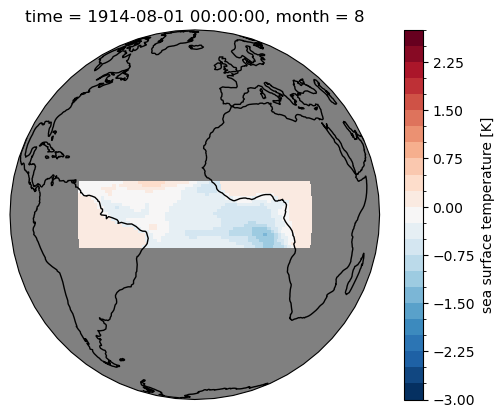

In [50]:
# quick test plot
p = anom['SST'].isel(member=5, time=7).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-20, 0), facecolor="gray"),
    transform=ccrs.PlateCarree(), levels=np.arange(-3, 3, 0.25)
)
p.axes.set_global()

p.axes.coastlines()

# Detrend
Remove later if not needed

In [52]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


anom_dtrend = detrend_dim(anom['SST'], dim='time')

# EOF

In [73]:
anom_members = [anom_dtrend.sel(member=m) for m in anom_dtrend['member']]
anom_members

[<xarray.DataArray (time: 1212, lat: 22, lon: 65)> Size: 14MB
 array([[[-0.24873674, -0.22294819, -0.24152878, ..., -0.17958824,
          -0.20421087, -0.22833564],
         [-0.27314792, -0.24490726, -0.24233882, ..., -0.17319407,
          -0.20470544, -0.23471399],
         [-0.30579042, -0.30095094, -0.26723919, ..., -0.20626624,
          -0.24921184, -0.27583718],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],
 
        [[-0.26468665, -0.26364364, -0.27553643, ..., -0.28749938,
          -0.28605582, -0.27953677],
         [-0.2236435 , -0.22497006, -0.25651556, ..., -0.28427726,
          -0.28386495, -0.26351994],
         [-0.23300356, -0.23939113, -0.23180066, ..., -0.30456247,
          -0.29791643,

In [74]:
model = xe.single.EOF(n_modes=3, use_coslat=True, normalized=False)

model.fit(anom_members, dim='time')
components = model.components()
PCs = model.scores(normalized=False)
xplained_var = model.explained_variance_ratio().values

In [92]:
len(components)

100

In [90]:
len(PCs)

3

# Scaling and normalizing

In [82]:
# scale by PC std
# nomalized in this package is L2 norm not STD


In [97]:
PCs[2][6]

<xarray.DataArray 'scores' ()> Size: 8B
array(6.58067309)
Coordinates:
    time     object 8B 1914-07-01 00:00:00
    month    int64 8B 7
    mode     int64 8B 3
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-06-30 15:15:14
    n_modes:        3
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [ ]:
# normalized by l2norm true as test
# PCs = model.scores()

pc_std = PCs.std()
pc_mean = PCs.mean()

normalized_PCs = (PCs - pc_mean) / pc_std
scaled_EOF = components * pc_std

In [11]:
PC1 = normalized_PCs.sel(mode=1)
PC2 = normalized_PCs.sel(mode=2)
PC3 = normalized_PCs.sel(mode=3)

In [62]:
'''
The very last plot starts in 1990, but for a 21-year rolling window,
the data should start in 1980. So you may have a bug somewhere.

For the variance plots, we should use JJA mean EANI and CANI. 
Before rolling, you should calculate the 3 month-mean and group them by year.
For example: 

EANI_JJA = EANI.where(EANId.time.dt.month.isin([7,8,9]),drop=True)
EANI_JJA_mean = EANI_JJA.groupby(EANI_JJA.time.dt.year).mean()
EANI_roll = EANI_JJA_mean.rolling(year=21, center=True).mean()
'''
# select only the summer of the index
EANI_JJA = EANI_roll.where(EANI_roll.time.dt.month.isin([6, 7, 8]), drop=True)
CANI_JJA = CANI_roll.where(CANI_roll.time.dt.month.isin([6, 7, 8]), drop=True)

EANI_JJA_mean = EANI_JJA.groupby(EANI_JJA.time.dt.year).mean()
CANI_JJA_mean = CANI_JJA.groupby(CANI_JJA.time.dt.year).mean()
var_roll = 21

EANI_var = EANI_JJA_mean.rolling(year=var_roll, center=True).var()
CANI_var = CANI_JJA_mean.rolling(year=var_roll, center=True).var()
# EANI_var = EANI.rolling(time=var_roll).var()
# CANI_var = CANI.rolling(time=var_roll).var()

CvE_r = CANI_var / EANI_var

# Plotting